## 분석에 필요한 모듈 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

`from sklearn.preprocessing import Imputer`의 경우 존재하지 않는 모듈이라는 오류가 떠서 제외하였습니다.

## 데이터 로딩

In [2]:
trainset = pd.read_csv('../input/train.csv')
testset = pd.read_csv('../input/test.csv')

#### ✅ 절대 경로와 상대 경로
- 절대 경로 : 어떠한 웹페이지나 파일이 가지고 있는 고유한 경로
- 상대 경로 : '현재 위치한 곳을 기준' 으로 한 경로

따라서, `trainset`과 `testset`의 경로는 절대 경로와 상대 경로 모두로도 사용할 수 있습니다. 위의 예시는 상대 경로를 사용한 것인데요.

`Kaggle/week01/input` 에 `train.csv`와 `test.csv`가 존재하고, 현재 작업 중인 디렉토리는

In [3]:
import os
os.getcwd()

'C:\\Users\\USER\\PycharmProjects\\Kaggle_local\\week01\\Eunhee'

`Kaggle/week01/Eunhee`입니다. 즉, 현재 디렉토리에서 한 단계 상위 디렉토리로 이동한 다음, `input` 으로 이동해야 비로소 `train.csv`와 `test.csv`를 이용할 수 있는 것이죠.
- / : 최상위 디렉토리로 이동
- ./ : 현재 디렉토리를 의미
- ../ : 한 단계 상위 디렉토리로 이동
    - 예) 두 단계 상위 디렉토리로 이동 시 ../../

자세한 설명은 [링크](https://88240.tistory.com/122) 의 글을 참고해 주세요.

## 데이터에 대한 사전 이해
- 몇 가지 **그룹**들이 정의되어 있고, 이러한 그룹에 속해 있는 특징들은 이름에 패턴을 포함(`ind`, `reg`, `car`, `calc`)합니다. **ind**는 individual, **reg**은 registration, **car**은 self-explanatory, **calc**은 calculated field 를 의미합니다.
- 접미사 `bin`은 binary feature 에 대해 사용됩니다.
- 접미사 `cat`은 categorical features 에 대해 사용됩니다.
- `bin`이나 `cat`이 없는 특징들은 실수나 정수입니다.
- 결측치는 `-1`으로 나타냅니다.
- 예측의 관심은 `target` 컬럼입니다. 이것은 해당 보험자에 대한 보험금 청구가 접수되었는지 여부를 나타냅니다.
- `id`는 데이터 인풋, 숫자형입니다.

In [4]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
print("Train dataset (rows, cols) :", trainset.shape, "\nTest dataset (rows, cols) :", testset.shape)

Train dataset (rows, cols) : (595212, 59) 
Test dataset (rows, cols) : (892816, 58)


training set 에는 59개의 컬럼이 있는데, test set 에는 58개의 컬럼이 있습니다. 이는 `target` 컬럼이 test set 에는 존재하지 않기 때문인데요. 파이썬의 `set` 자료형과 차집합 원리를 이용하여 쉽게 확인할 수 있씁니다.

In [6]:
print("Columns in train and not in test dataset :", set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset : {'target'}


## 메타데이터
- use : input, ID, target
- type : nominal, interval, ordinal, binary
- preserve : True, False
- dataType : int, float, char
- category : ind, reg, car,calc

In [7]:
data = []
for feature in trainset.columns:
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'

    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == int:
        type == 'integer'

    preserve = True
    if feature == 'id':
        preserve = False

    dtype = trainset[feature].dtype

    category = 'none'
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'

    feature_dictionary = {
        'varname' : feature,
        'use' : use,
        'type' : type,
        'preserve' : preserve,
        'dtype' : dtype,
        'category' : category
    }
    data.append(feature_dictionary)

metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,binary,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,categorical,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


모든 범주형 변수들을 가져옵니다.

In [8]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11'],
      dtype='object', name='varname')

주어진 카테고리를 기준으로 분류합니다.

In [9]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


그 다음에는 이를 type을 기준으로 분류합니다.

In [10]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,20
2,input,categorical,16
3,input,real,21
4,target,binary,1


## 데이터 분석과 통계
### 타깃 변수

<Figure size 432x288 with 0 Axes>

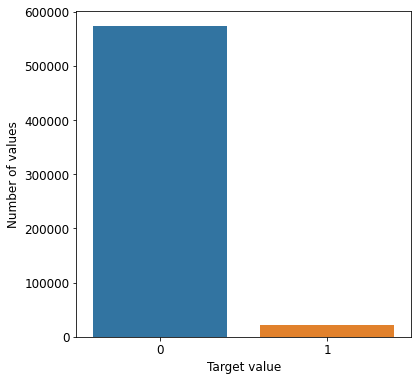

In [20]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values

sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

-`.value_counts()` : 컬럼/Series 의 unique value 들을 count 해주는 함수로, unique value 들과 count 들을 리턴합니다.
- `x` : `target`의 분류, 즉 0 또는 1
- `y` : `target`의 분류별 개수, 예를 들어 0에는 몇 개, 1에는 몇 개
- `plt.tick_params` : 눈금 스타일을 적용하는 함수, 이 설정은 x축&y축 모두에 적용하고, major 눈금으로!

## 실제 feature 들

`metadata.type`이 `real`이고, `metadata.preserve`가 `True`인 변수들을 찾습니다.

In [34]:
metadata[(metadata.type == 'real') & (metadata.preserve)].T

varname,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
use,input,input,input,input,input,input,input,input,input,input,...,input,input,input,input,input,input,input,input,input,input
type,real,real,real,real,real,real,real,real,real,real,...,real,real,real,real,real,real,real,real,real,real
preserve,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
category,registration,registration,registration,car,car,car,car,calculated,calculated,calculated,...,calculated,calculated,calculated,calculated,calculated,calculated,calculated,calculated,calculated,calculated


In [37]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,...,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,...,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,...,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000,...,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000,...,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000,...,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


이러한 변수들을 `trainset`에서 골라내었습니다.

In [45]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [46]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### 결측치가 있는 feature 들
`ps_reg_o3`, `ps_car_12`, `ps_car_14`가 결측치를 가지고 있다고 합니다만 실행해 보니 모든 컬럼에서 결측치를 확인할 수 없었습니다.

In [52]:
trainset.isnull().sum().sum()

0

### Registration feature 들
`ps_reg_01`과 `ps_reg_02`은 분모가 10인 (0.1, 0.2 처럼) 분수 형태의 값들을 가지는 변수입니다.
### Car feature 들
`ps_car_12`는 10을 곱하여 제곱하면 자연수에 근접하며, `ps_car_15`는 제곱하면 자연수가 되는 특징이 있습니다.

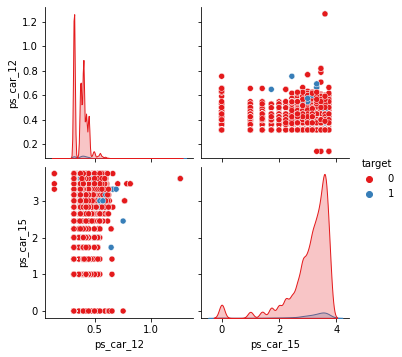

In [57]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

- `sns.pairplot` : `sample`을 가지고 그림을 그리고, `target`을 색깔 기준으로 삼습니다, 색상은 `Set1`에 사전 지정된 색깔을 사용하며 대각선에는 커널 밀도 추정 곡선을 볼 수 있게(`kde`) 합니다.
> 커널 밀도 추정 곡선 : non-parametric 밀도추정 방법 중 하나로서 커널함수(kernel function)를 이용하여 히스토그램 방법의 문제점을 개선한 방법